In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
import skimage as ski
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

BASEDIR = Path("/global/public/chabud-ecml-pkdd2023/")
fn = BASEDIR / "train_eval.hdf5"

In [2]:
def to_xarray(dataset, pretty_band_names=True):
    """Convert a single example into an xarray for easy access"""
    
    if pretty_band_names:
        BANDS = ["coastal_aerosol", "blue", "green", "red",
                 "veg_red_1", "veg_red_2", "veg_red_3", "nir", 
                 "veg_red_4", "water_vapour", "swir_1", "swir_2"]
    else:
        BANDS = ["1", "2", "3", "4", "5", "6", "7", "8", "8a", "9", "11", "12"]
        
    post = dataset["post_fire"][...].astype("float32") / 10000.0
    
    # Da `pre_fire` manchmal fehlt ersetzen wir es durch 0 Werte was
    # eh der Platzhalter für einen fehlenden Messwert ist.
    try:
        pre = dataset["pre_fire"][...].astype("float32") / 10000.0
    except KeyError:
        pre = np.zeros_like(post, dtype="float32")
        
    # Da die Maske nur ein "Band" hat können wir die dritte Dimension einfach
    # weglassen. Das erreichen wir in dem wir mit `0` am Ende indizieren.
    mask = dataset["mask"][..., 0].astype("bool")
    
    return {"pre": xr.DataArray(pre, dims=["x", "y", "band"], coords={"x": range(512), "y": range(512), "band": BANDS}),
            "post": xr.DataArray(post, dims=["x", "y", "band"], coords={"x": range(512), "y": range(512), "band": BANDS}),
            "mask": xr.DataArray(mask, dims=["x", "y"], coords={"x": range(512), "y": range(512)}),
            "fold": dataset.attrs["fold"]}

The following code was used and edited in order to analize the effect on the median and standart deviation if data with a too small masks are removed. This was done so that the Neuronal Network gets trained to predict larger masks.

In [3]:
res = []

with h5py.File(fn, "r") as fd:
    for name in fd:
        ds = to_xarray(fd[name])
        mask = ds["mask"].values
        burned = np.sum(mask) / (512*512)
        #if(burned==1):
            #print(name)
        if(burned<=0.02):
            continue;
        res.append({"burned": burned})    
        #break;

In [4]:
df = pd.DataFrame(res)
del res

0.23417302673938228
0.26324914249621933


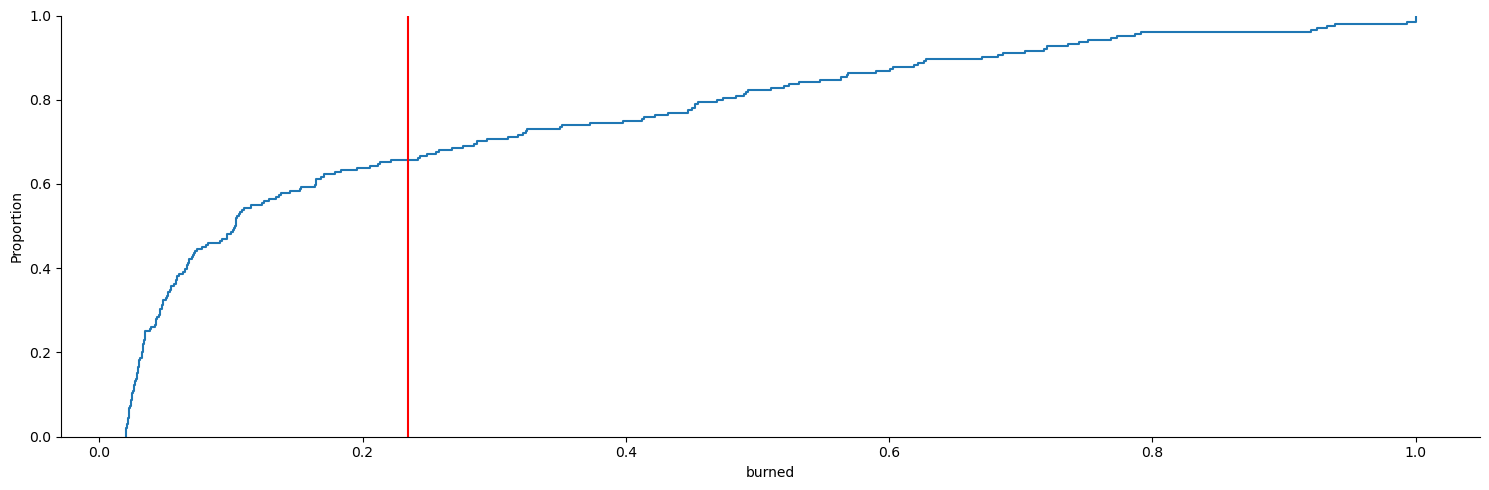

In [5]:
mean = np.mean(df["burned"])
std = np.std(df["burned"])
print(mean)
print(std)
#print(mean-std)
fig_1 = sns.displot(df, x="burned", kind ="ecdf", height=5, aspect=3)
fig_1.ax.axvline(mean, color = "red")
#fig_1.ax.axvline(mean-std, color = "blue")
#fig_1.ax.axvline(std+mean, color = "blue")
#fig_1.savefig('size_mask_no_2.eps' , format = 'eps')

In [6]:
# wir sehen, dass die meisten Masken zwiscehn 0 und 20% des Bildes abdecken

In [7]:
# ein treshhold von 2% für die Masken sorgt schon dafür, dass der Datensatz ausgeglichener wirkt

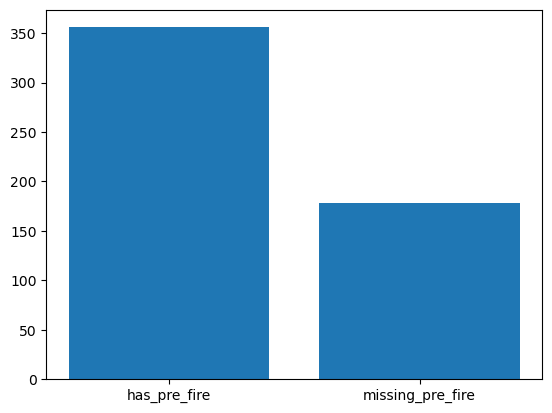

In [12]:
res_has_pre = []
res_no_pre = []
with h5py.File(fn, "r") as fd:
    for name, ds in fd.items():
        if "pre_fire" in ds:
            res_has_pre.append(name)
        else:
            res_no_pre.append(name)
        
x = ["has_pre_fire", "missing_pre_fire"]  # X-axis values
y = [len(res_has_pre), len(res_no_pre)]  # Y-axis values

plt.bar(x, y)
#plt.show()

plt.savefig('missing_prefire.eps')

In [ ]:
df